Using TensorFlow backend.


====================preparating the data...====================
11493376/11490434 [==============================] - 4s 0us/step
====================summary of this model====================
reconstruction Tensor("Mean:0", shape=(), dtype=float32) kl Tensor("mul:0", shape=(?,), dtype=float32)
seq_vaeの構成
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28)       0                                            
__________________________________________________________________________________________________
cu_dnngru_1 (CuDNNGRU)          (None, 40)           8400        input_1[0][0]                    
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 3)            123         cu_dnngru_1[0][0]                
__

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:143: UserWarning: Output "time_distributed_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "time_distributed_1" during training.


Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 24s 449us/step - loss: 0.2957 - val_loss: 0.2674
Epoch 2/100
54000/54000 [==============================] - 23s 420us/step - loss: 0.2589 - val_loss: 0.2559
Epoch 3/100
54000/54000 [==============================] - 23s 428us/step - loss: 0.2551 - val_loss: 0.2547
Epoch 4/100
54000/54000 [==============================] - 23s 419us/step - loss: 0.2536 - val_loss: 0.2522
Epoch 5/100
54000/54000 [==============================] - 23s 430us/step - loss: 0.2513 - val_loss: 0.2490
Epoch 6/100
54000/54000 [==============================] - 22s 404us/step - loss: 0.2482 - val_loss: 0.2476
Epoch 7/100
54000/54000 [==============================] - 23s 428us/step - loss: 0.2459 - val_loss: 0.2431
Epoch 8/100
54000/54000 [==============================] - 23s 432us/step - loss: 0.2435 - val_loss: 0.2409
Epoch 9/100
54000/54000 [==============================] - 23s 427us/step - loss: 0.240

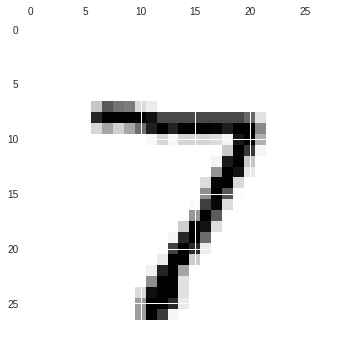

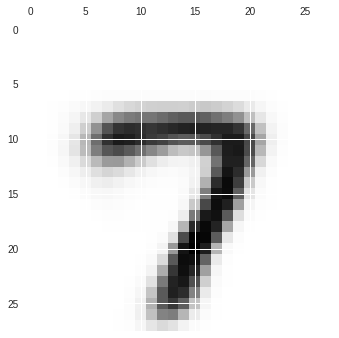

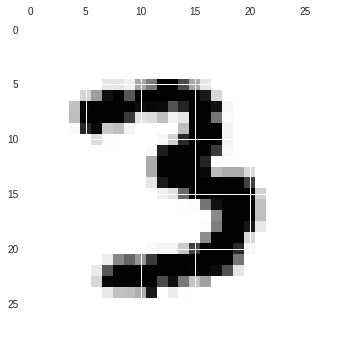

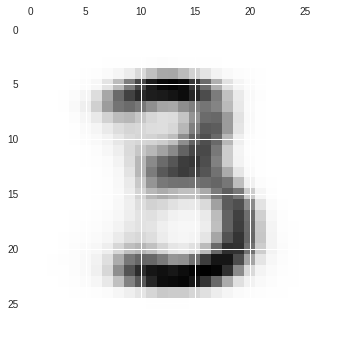

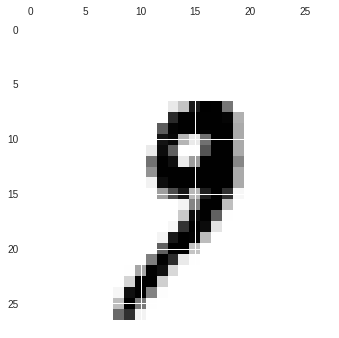

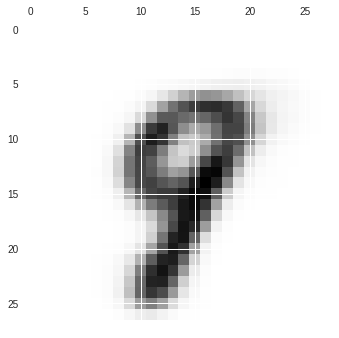

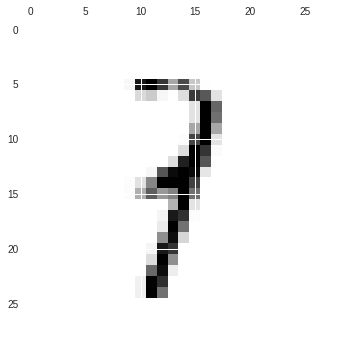

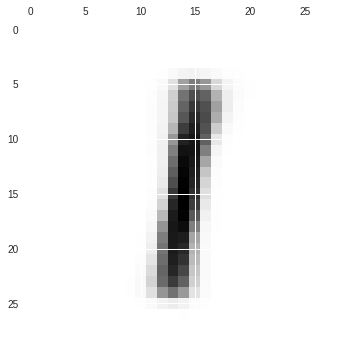

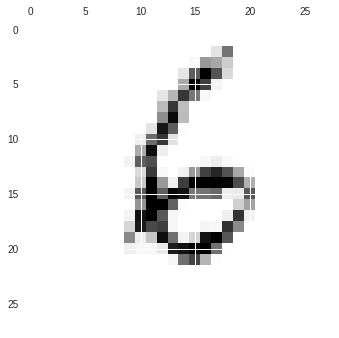

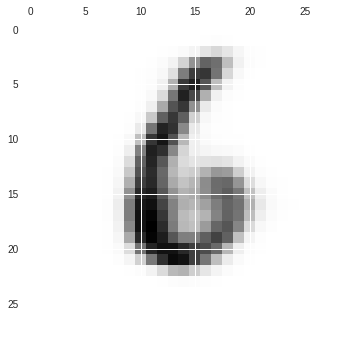

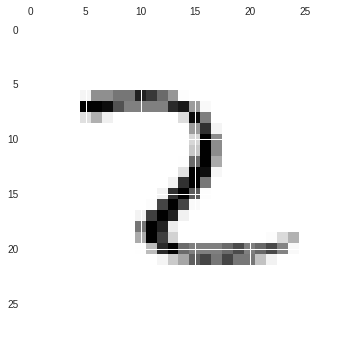

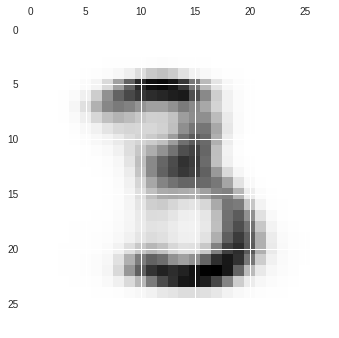

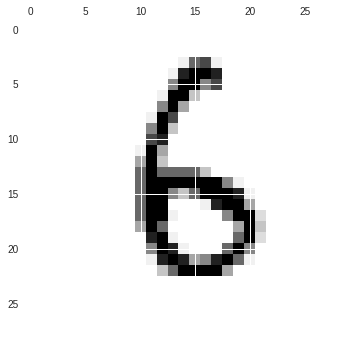

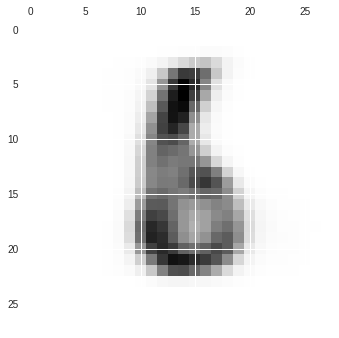

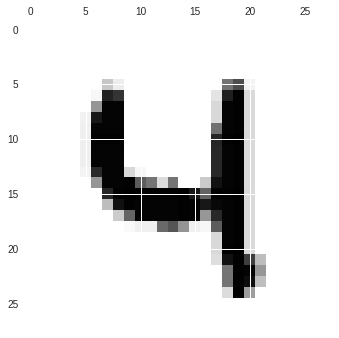

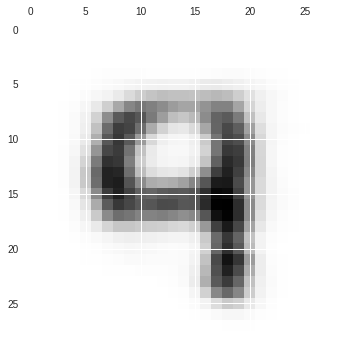

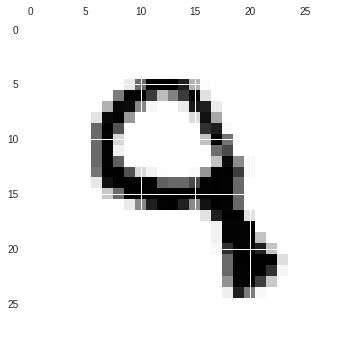

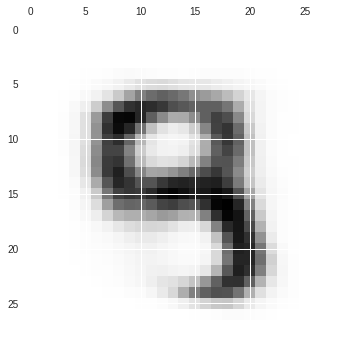

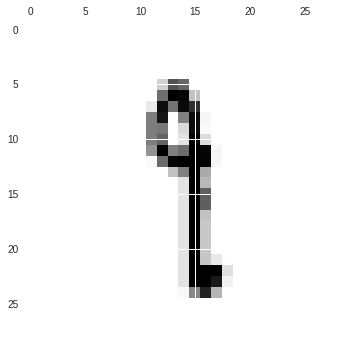

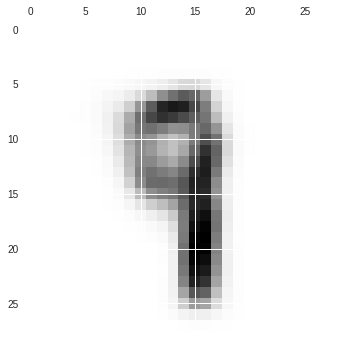

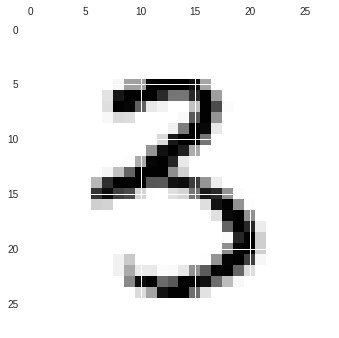

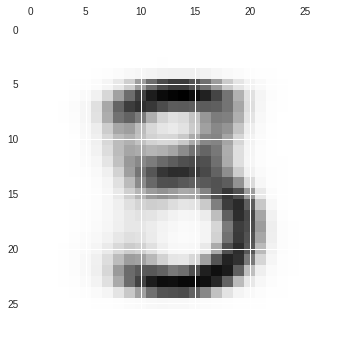

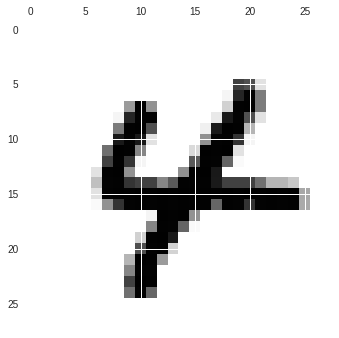

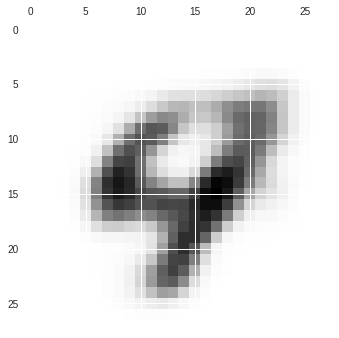

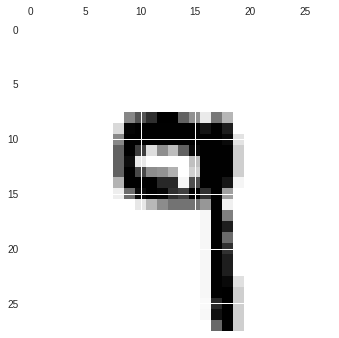

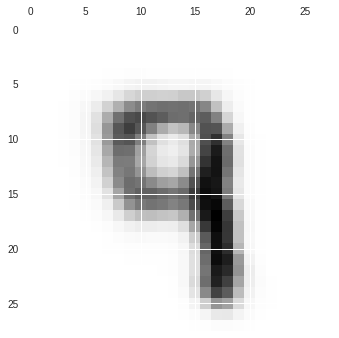

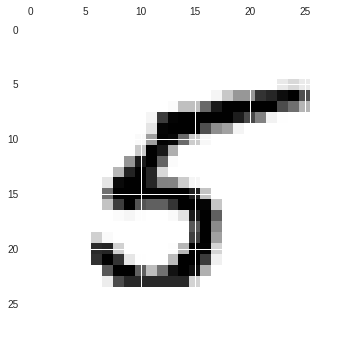

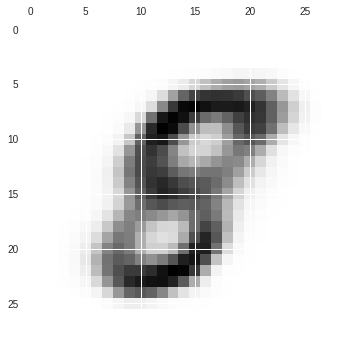

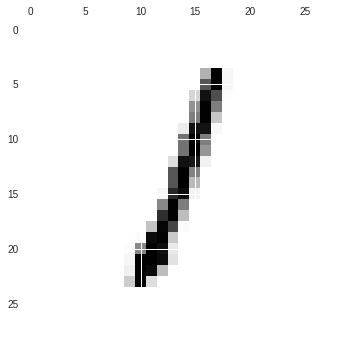

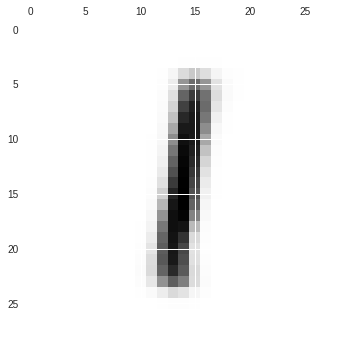

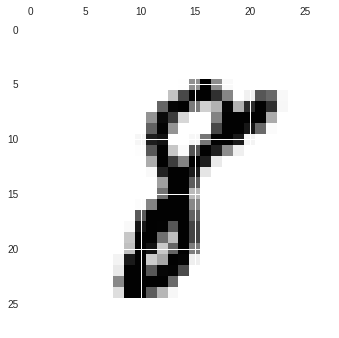

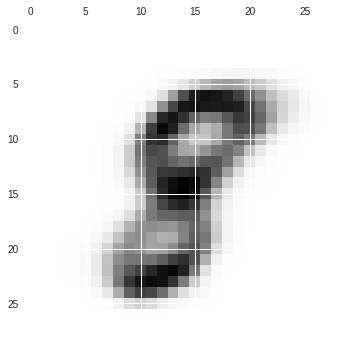

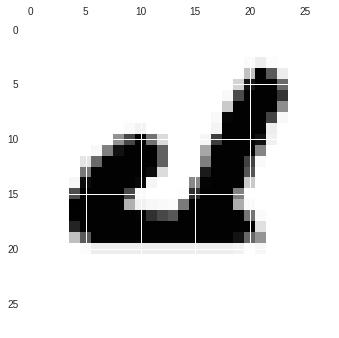

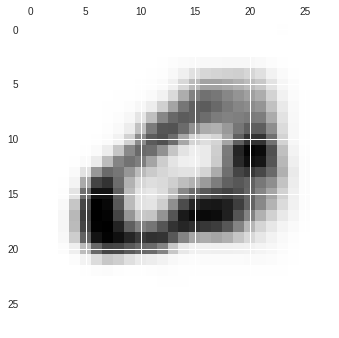

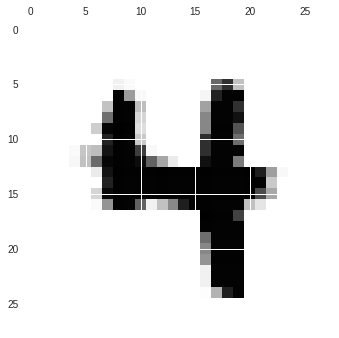

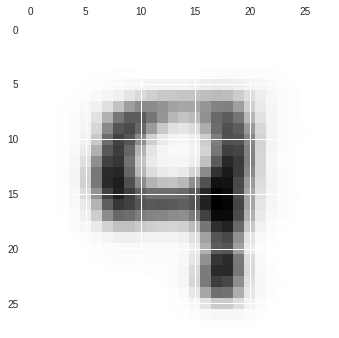

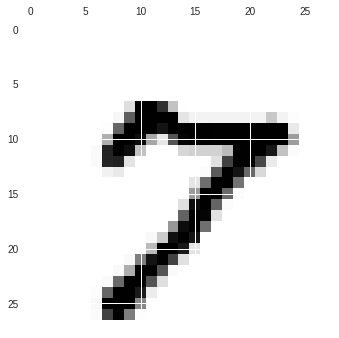

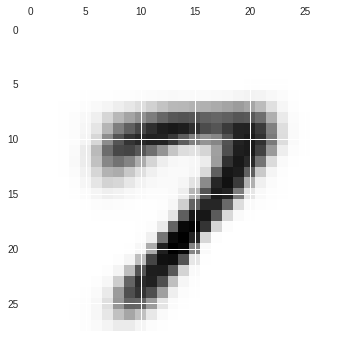

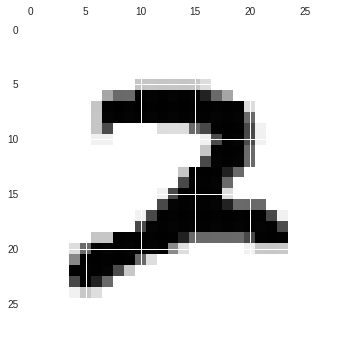

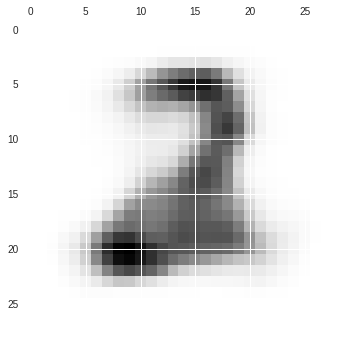

'\n121ぐらい\n'

In [1]:
"""
gruを用いたvae

vaeで時系列に見立てたMNISTを生成
"""
import math
import os
import numpy as np
from keras.layers import Input, InputLayer, Dense, RepeatVector, Lambda, TimeDistributed
# from keras.layers import GRU
from keras.layers import CuDNNGRU as GRU  # GPU用
from keras.models import Model, Sequential
from keras.callbacks import TensorBoard, EarlyStopping
from keras.optimizers import adam
from keras import backend as K
# データの準備


def prepare_data():
    """
    戻り値
      規格化された
      x_train, x_test
    """
    from keras.datasets import mnist
    (x_train, _), (x_test, _) = mnist.load_data()
    x_train, x_test = x_train/255, x_test/255
    # >>> x_train.shape, x_test.shape
    # ((60000, 28, 28), (10000, 28, 28))
    # これを(None, NUM_TIMESTEPS, NUM_INPUT_DIM)と対応させる
    global NUM_TIMESTEPS, NUM_INPUT_DIM
    _, NUM_TIMESTEPS, NUM_INPUT_DIM = x_train.shape
    return x_train, x_test


def seq_vae():
    """
    入力(input)
    ↓
    GRU(encoder)
    ↓
    内部状態
    ↓   ↓
    mean, log_var
    ↓
    zをサンプリング(ここまでencoder)
    ↓（このzを復元された内部状態だとして）
    GRU(decoder)
    ↓
    全結合層(出力)


    戻り値
     model
    """
    LATENT_DIM = 40
    CODING_DIM=3

    def sampling(args):
        """
        z_mean, z_log_var=argsからzをサンプリングする関数
        戻り値
            z (tf.tensor):サンプリングされた潜在変数
        """
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        # by default, random_normal has mean=0 and std=1.0
        epsilon = K.random_normal(shape=(batch, dim))
        # K.exp(0.5 * z_log_var)が分散に標準偏差になっている
        # いきなり標準偏差を求めてしまっても構わないが、負を許容してしまうのでこのようなトリックを用いている
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    # encoderの定義
    inputs = Input(shape=(NUM_TIMESTEPS, NUM_INPUT_DIM))
    # (None, NUM_TIMESTEPS,NUM_INPUT_DIM)
    x = GRU(LATENT_DIM)(inputs)
    # (None, CODING_DIM)
    z_mean = Dense(CODING_DIM, name='z_mean')(x)  # z_meanを出力
    # (None, CODING_DIM)
    z_log_var = Dense(CODING_DIM, name='z_log_var')(x)  # z_sigmaを出力
    # (None, LATENT_DIM)

    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(CODING_DIM,), name='z')(
        [z_mean, z_log_var])  # 2つの変数を受け取ってランダムにサンプリング
    # (None, CODING_DIM)
    encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder")
    # encoder部分は入力を受けて平均、分散、そこからランダムサンプリングしたものの3つを返す

    # decoderの定義
    latent_inputs = RepeatVector(
        NUM_TIMESTEPS)(z)
    # (None, NUM_TIMESTEPS, CODING_DIM)
    x = GRU(LATENT_DIM, return_sequences=True)(latent_inputs)
    # (None, NUM_TIMESTEPS, LATENT_DIM)
    outputs = TimeDistributed(
        Dense(NUM_INPUT_DIM, activation='sigmoid'))(x)
    # (None, NUM_TIMESTEPS, NUM_INPUT_DIM)

    # instantiate decoder model
    # decoder = Model(z, outputs, name='decoder')
    # print("decoderの構成")
    # decoder.summary()

    # デコーダーとエンコーダーの結合
    # encoderの出力の3つめ、つまりzを入力として、decoderを実行する
    vae = Model(inputs, outputs, name='seq_vae')

    # 損失関数をこのモデルに加える
    def loss(inputs, outputs):
        """
        損失関数の定義
        """
        from keras.losses import binary_crossentropy
        z_mean, z_log_var, _ = encoder(inputs)
        reconstruction_loss = binary_crossentropy(
            K.flatten(inputs), K.flatten(outputs))
#         reconstruction_loss *= NUM_INPUT_DIM*NUM_TIMESTEPS
        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        
        lam = 0.01
        print("reconstruction",reconstruction_loss,"kl",kl_loss)
        return K.mean((1-lam)*reconstruction_loss + lam*kl_loss)#正規分布っ

    vae.add_loss(loss(inputs, outputs))
    print("seq_vaeの構成")
    vae.summary()
    return vae


if __name__ == "__main__":

    print("="*20+"preparating the data..."+"="*20)

    x_train, x_test = prepare_data()
    print("="*20+"summary of this model"+"="*20)
    seq_vae = seq_vae()

    seq_vae.compile(optimizer="nadam")#adam(lr=0.005))
    # 学習
    seq_vae.fit(x_train,
                epochs=100,
                batch_size=64,
                shuffle=True,
                validation_split=0.1,
                callbacks=[TensorBoard(log_dir="./MNIST_gru_vae/"), EarlyStopping(patience=3)])

    seq_vae.save('./MNIST_gru_vae/MNIST_gru_vae.h5')
    encoder=K.function([seq_vae.input],[seq_vae.get_layer("z_mean").output])
    decoder=K.function([seq_vae.get_layer("z").output],[seq_vae.layers[-1].output])
    # 推論
    x_pred = seq_vae.predict(x_test)

    import matplotlib.pyplot as plt
    # データをプロット
    for true, pred in zip(x_test[::500], x_pred[::500]):
        plt.matshow(true)

        plt.matshow(pred)
        plt.show()

"""
121ぐらい
"""


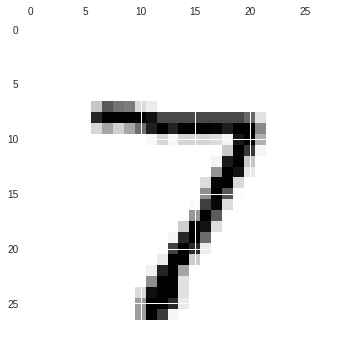

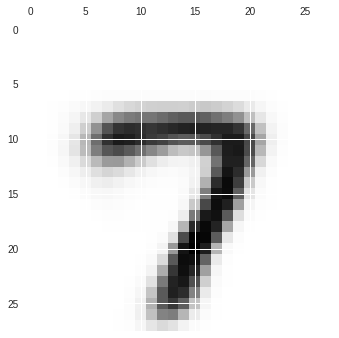

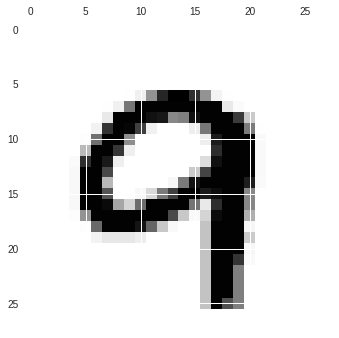

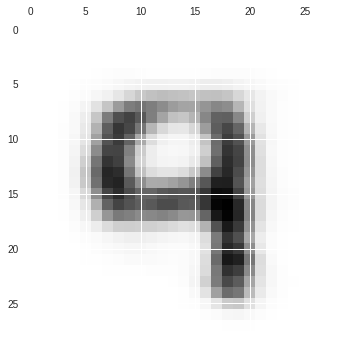

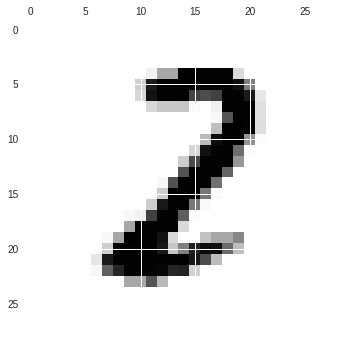

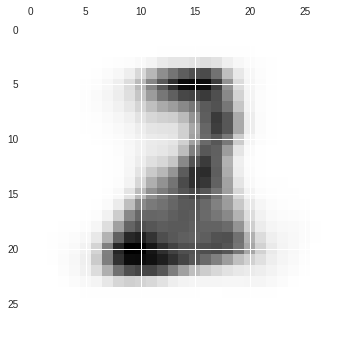

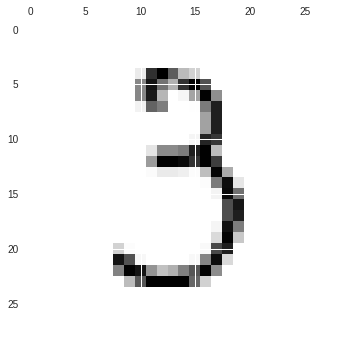

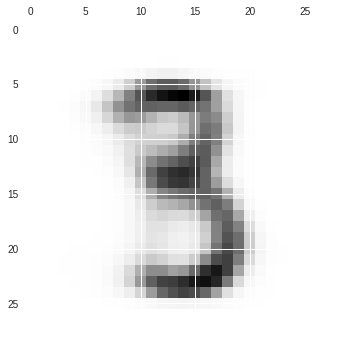

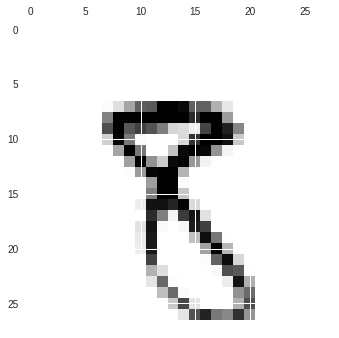

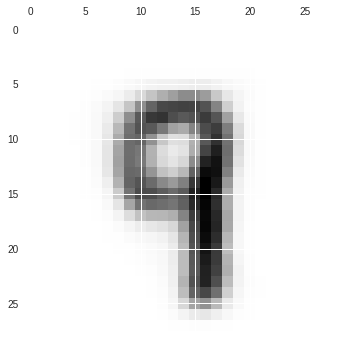

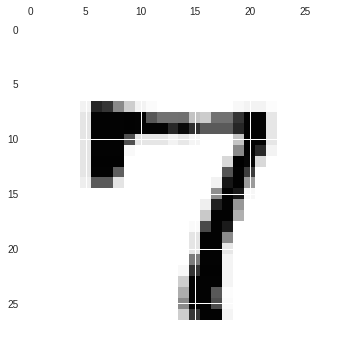

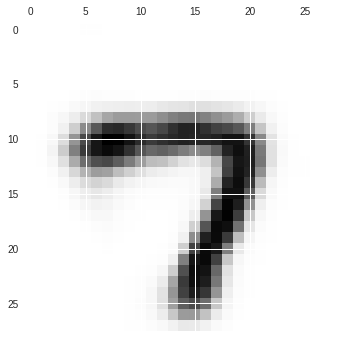

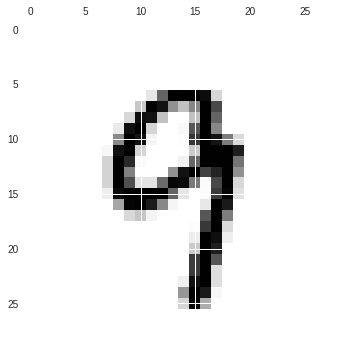

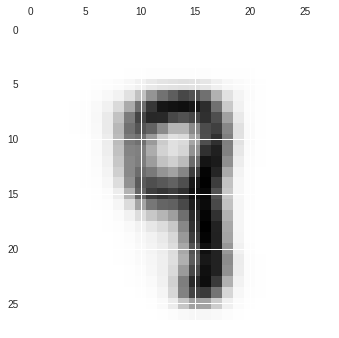

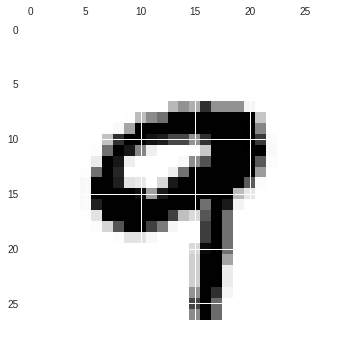

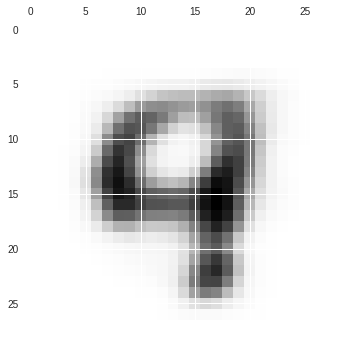

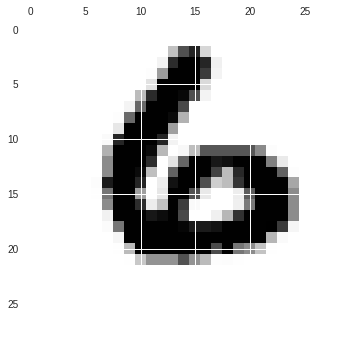

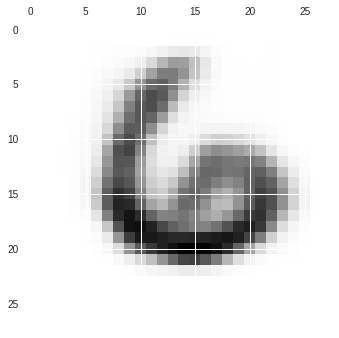

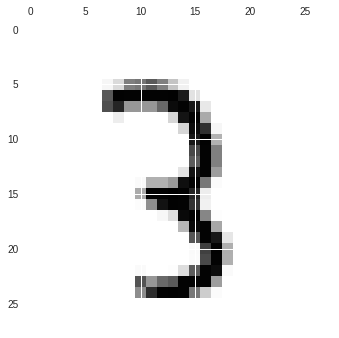

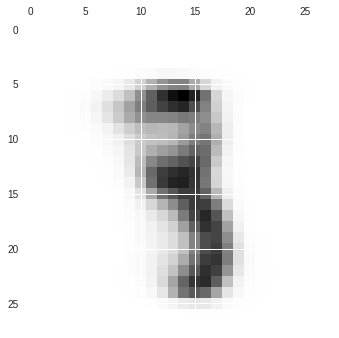

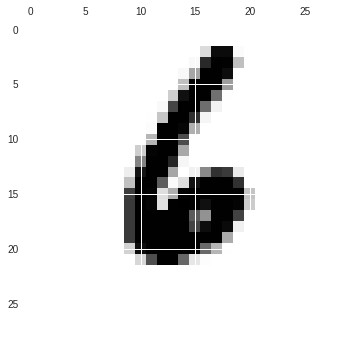

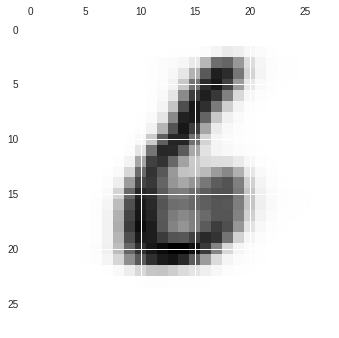

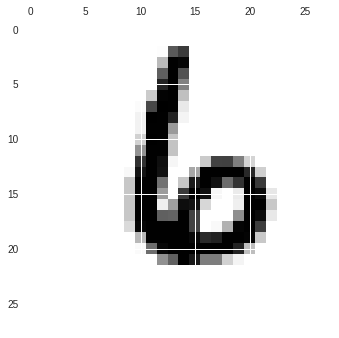

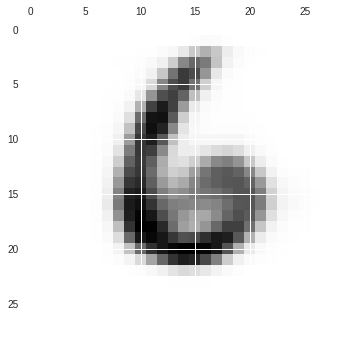

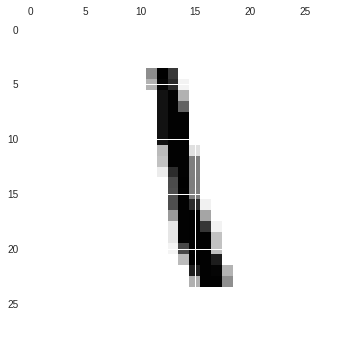

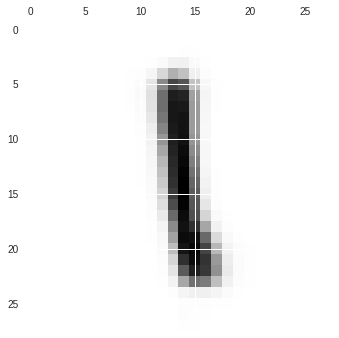

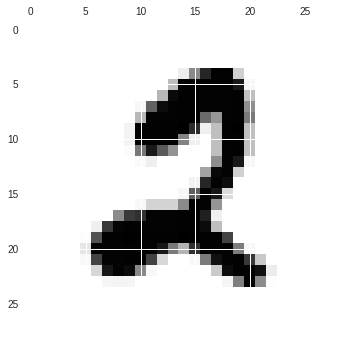

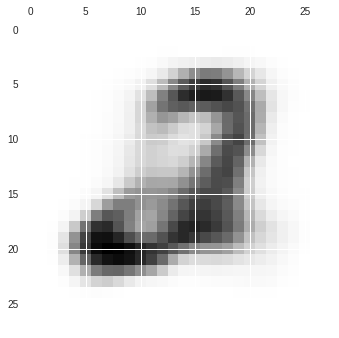

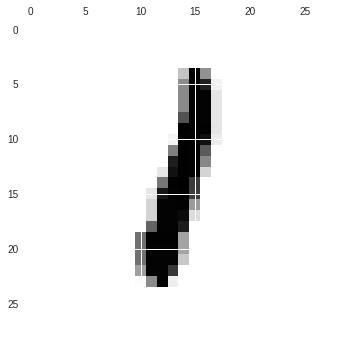

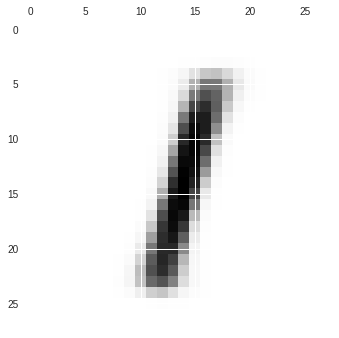

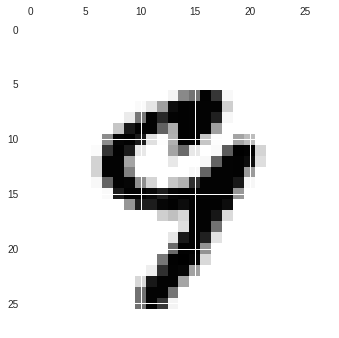

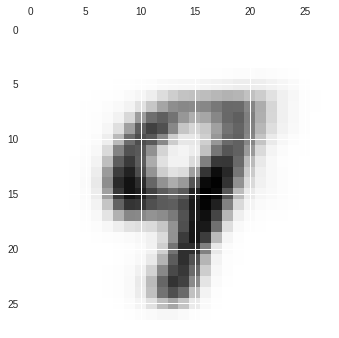

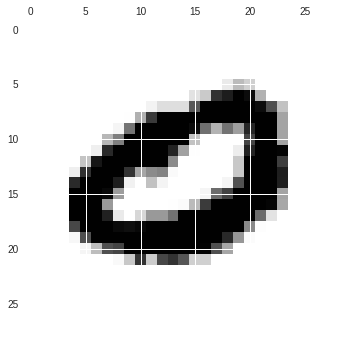

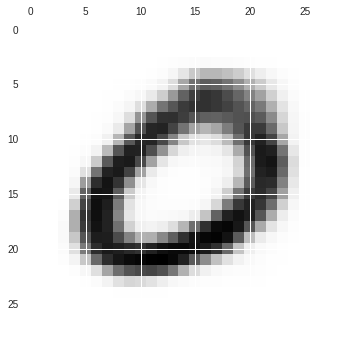

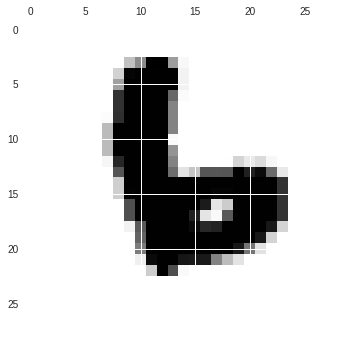

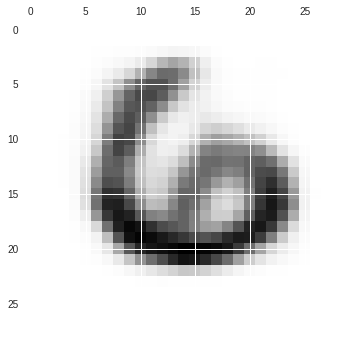

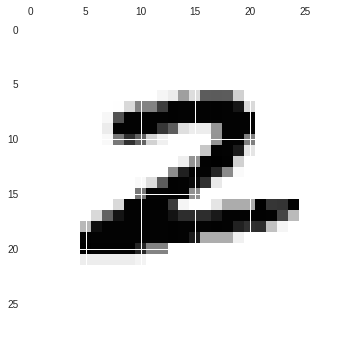

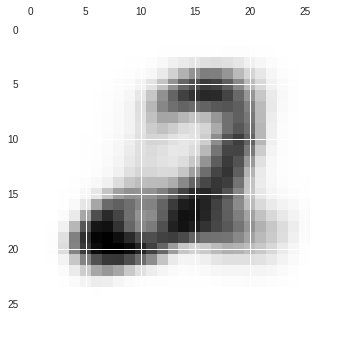

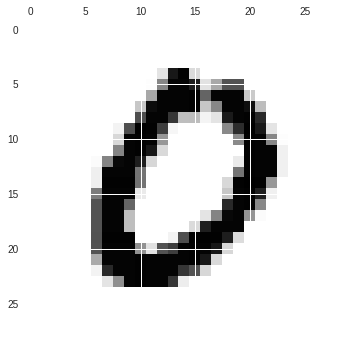

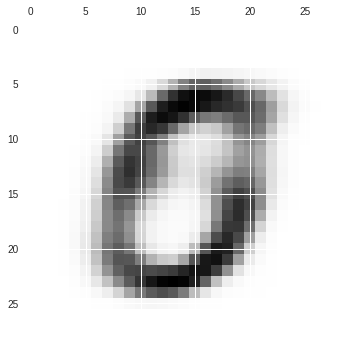

In [2]:
    for true, pred in zip(x_test[::501], x_pred[::501]):
        plt.matshow(true)

        plt.matshow(pred)
        plt.show()

In [3]:
coded=encoder([x_test])[0]
coded.max(), coded.min(),coded.mean()

(2.846611, -2.4205182, 0.012356371)

1.4621443899649156


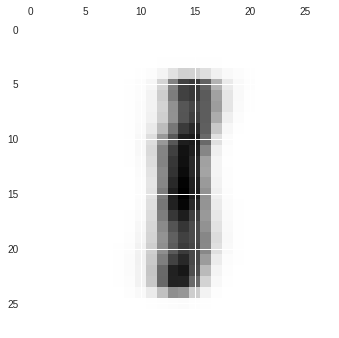

2.1013994906455227


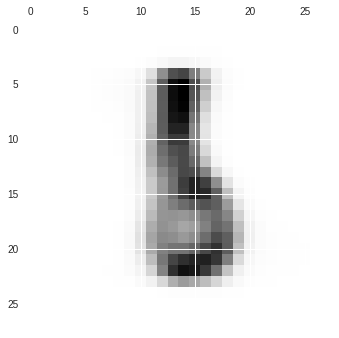

2.2033798885111513


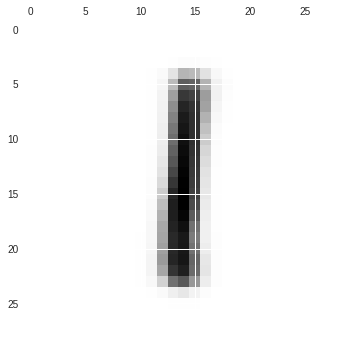

2.0019440923522325


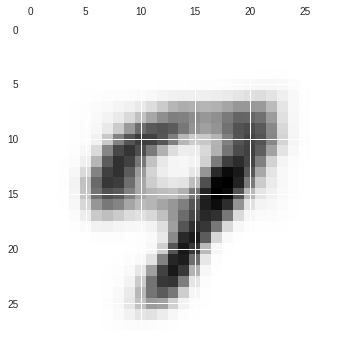

0.6210833913064132


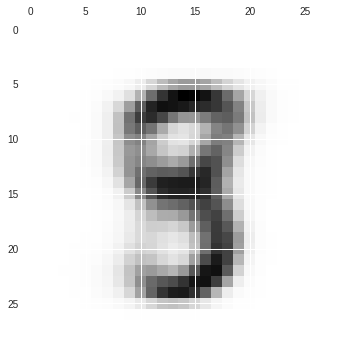

1.3209580099567217


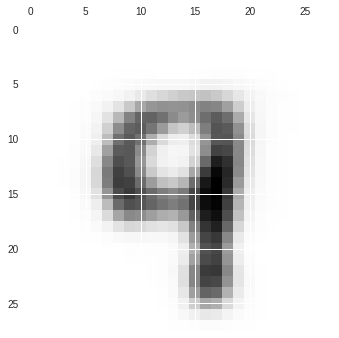

0.9291822536595657


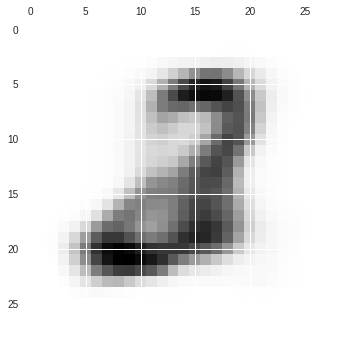

2.539509572045289


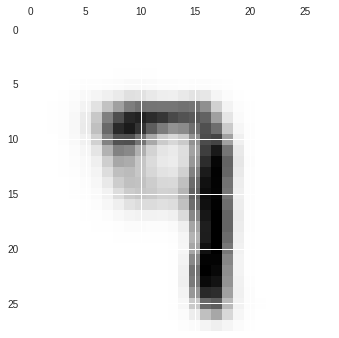

1.833330194794805


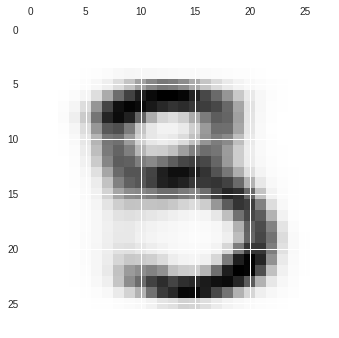

2.8780072720427325


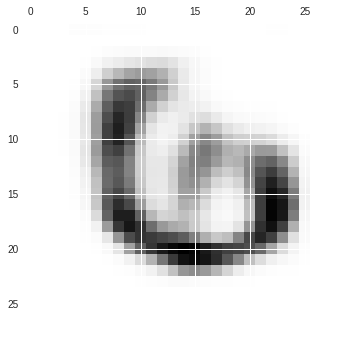

3.9560299941562853


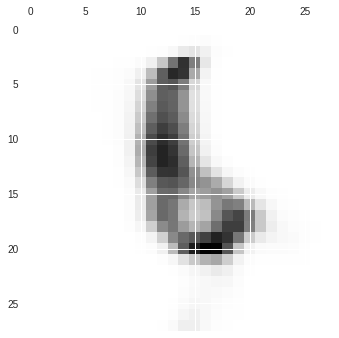

0.9178153732920996


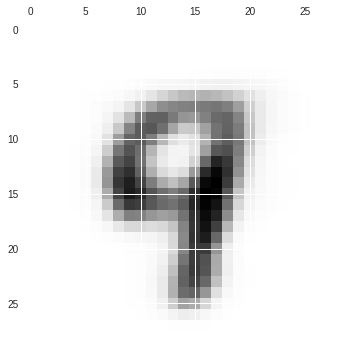

3.6104994649668765


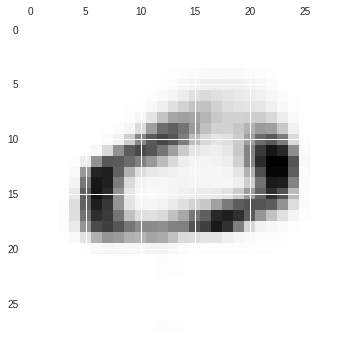

2.319848955316995


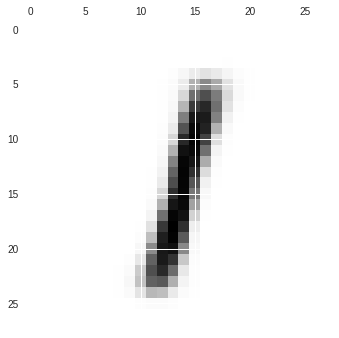

1.1637989782117593


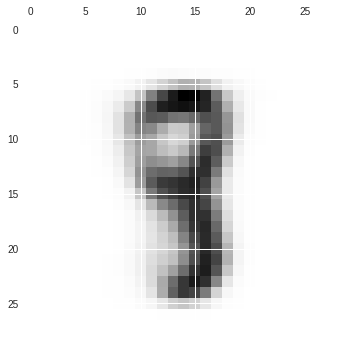

3.453835668158551


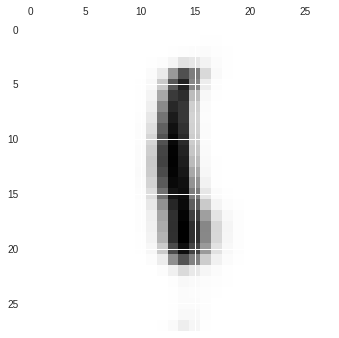

1.3968421175097565


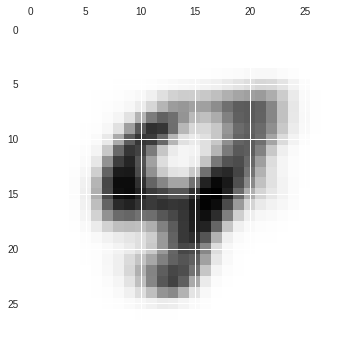

1.2377149181019427


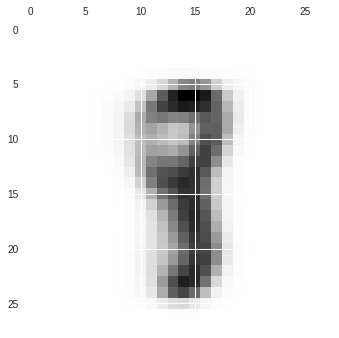

1.2547237961842528


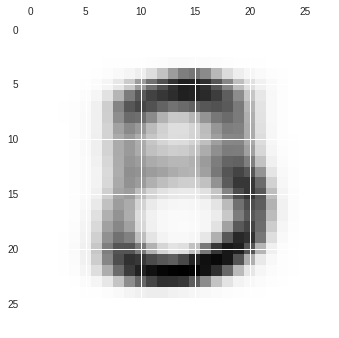

3.3159428080494497


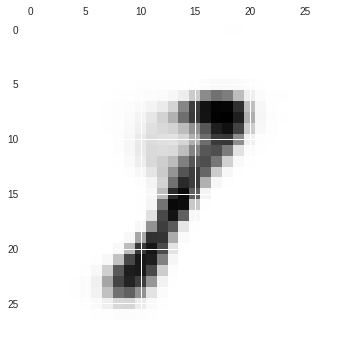

In [4]:
#数字っぽいものを出力させる
gauss=np.random.normal(0,1.3,size=(20,3))
gen = decoder([gauss])[0]
for g, r in zip(gen, gauss):
  print(np.linalg.norm(r))
  plt.matshow(g)
  plt.show()

8.248093567222043


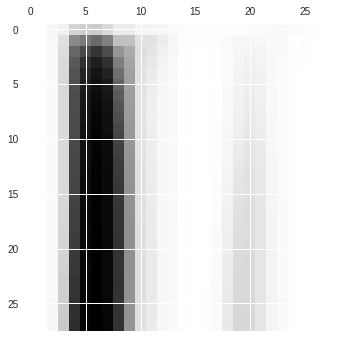

21.145476508123778


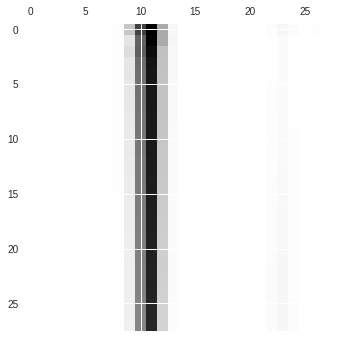

17.895200859989494


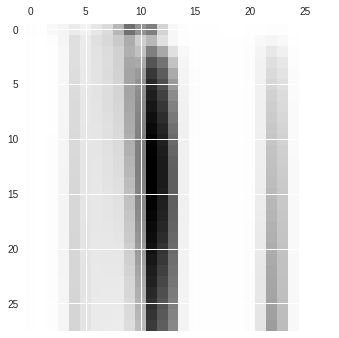

20.720637299527734


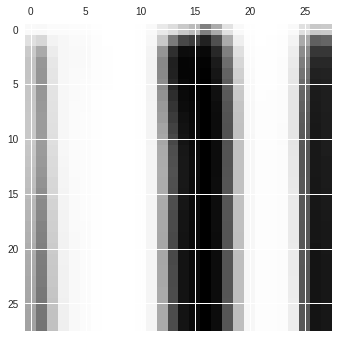

9.09236710637112


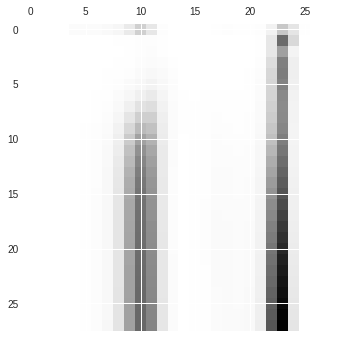

8.127962865622555


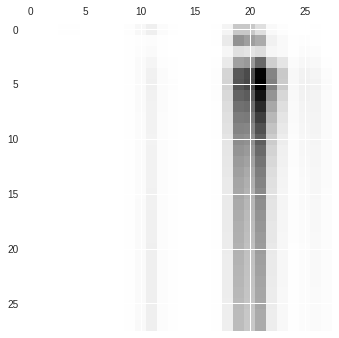

9.421864870194426


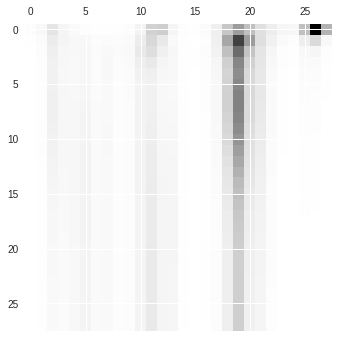

15.620876659606997


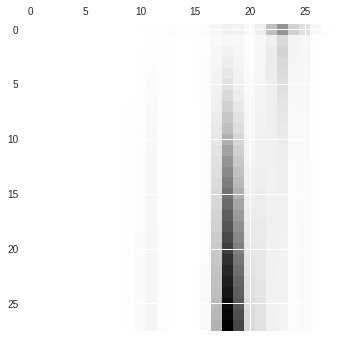

24.34511846510838


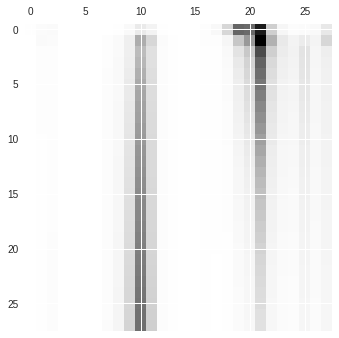

20.823592726600307


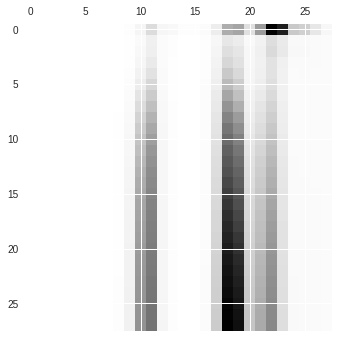

25.298485980330568


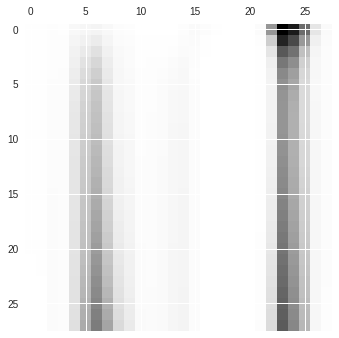

2.164106654430766


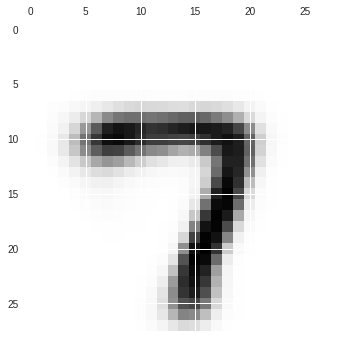

18.736385811408656


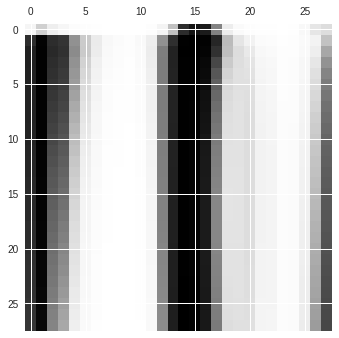

10.207507520670852


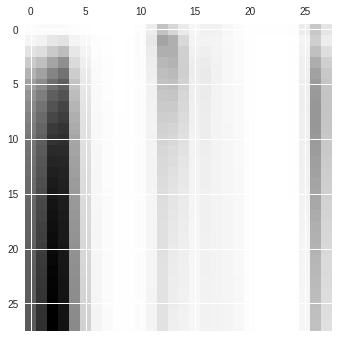

16.823527784712347


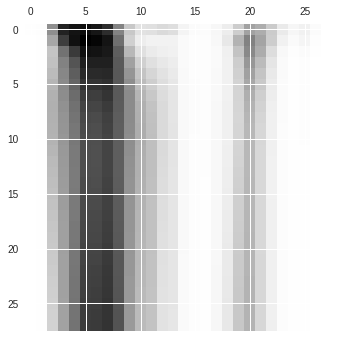

18.598146437082775


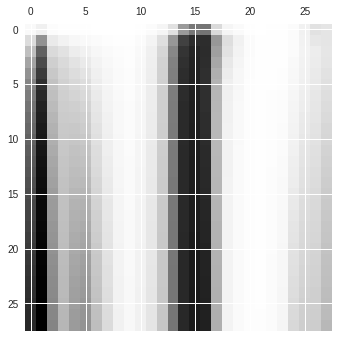

13.03595059516643


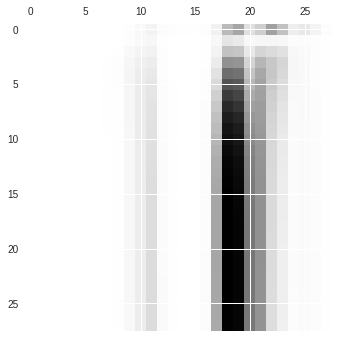

13.858849988200602


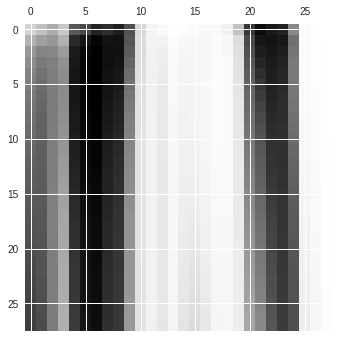

9.364058437049422


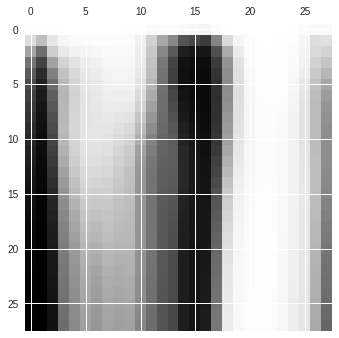

24.455278134259096


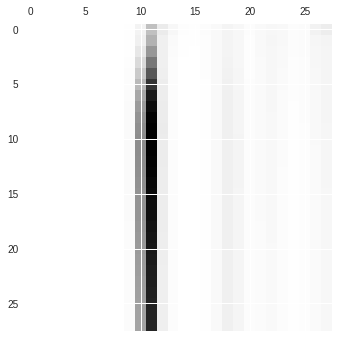

In [5]:
#めちゃくちゃなものを出力させる
#数字っぽいものを出力させる
gauss=np.random.normal(0,10,size=(20,3))
gen = decoder([gauss])[0]
for g, r in zip(gen, gauss):
  print(np.linalg.norm(r))
  plt.matshow(g)
  plt.show()

In [11]:
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode()
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))

In [0]:
from keras.datasets import mnist

(_),(_,y_test)=mnist.load_data()

In [0]:
import pandas as pd

In [0]:
df=pd.concat([pd.DataFrame(coded),pd.Series(y_test,name="label")],axis=1)

In [12]:
#正規分布になっているか確認する

configure_plotly_browser_state()

data=[]
for i in range(len(set(y_test))):
  trace=go.Scatter3d(
      x=df[df.label==i].iloc[:,0],
      y=df[df.label==i].iloc[:,1],
      z=df[df.label==i].iloc[:,2],
      mode="markers",
      marker=dict(
          size=1.5,
          opacity=0.5
      ),
      name=str(i)
  )
  data.append(trace)



layout = go.Layout(
    width=500,
    height=500,
)

fig = go.Figure(data=data)

py.iplot(fig)